<a href="https://colab.research.google.com/github/microprediction/martingale/blob/main/ctgan_synthetic_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install git+https://github.com/microprediction/martingale.git
!pip install ctgan

  Cloning https://github.com/microprediction/martingale.git to /tmp/pip-req-build-mbkiovp9
  Running command git clone --filter=blob:none --quiet https://github.com/microprediction/martingale.git /tmp/pip-req-build-mbkiovp9
  Resolved https://github.com/microprediction/martingale.git to commit d4edf54486ad31e63d3df498bcfe8826cb5d42f5
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.6 MB/s eta 0:00:00


Parameters: {'time_step': np.float64(0.13851438142135108), 'volatility_scale': np.float64(3537.1907129129213), 'correlation_rho': np.float64(0.5535651290747148), 'relative_jump_size': np.float64(1.2184634333395732), 'mean_reversion_speed': np.float64(0.9165666661963522), 'jump_intensity': np.float64(0.07099742246480593), 'noise_mean_reversion': np.float64(0.30043788120175197), 'epsilon_correlation': np.float64(0.11507485362502382), 'relative_noise_scale': np.float64(0.9453413554350746), 'noise_evolution_rate': np.float64(0.23987011134564956)}
{'x': np.float64(-113.35880821110253), 'y': np.float64(-113.35880821110253)}


Write an example simulation for a generative model like the following.


1.   A univariate time-series 'dove_location' from 'y' in brown_gen()
2.   A ground truth 'x' also from brown_gen()
3.   A collection 'falcon_location','falcon_id' where falcon_id is an interger. Let's say there are about 10 falcons chasing the dove.

To model each falcon, assume the following:


*   The falcon observes 'x' with uncertainty (some more accurately than others and the accuracy varies slowly over time)
*   The falcon also have a tendency to follow other falcons a little. Some falcons sometimes exhibit a delay before they do this.

Assume brown_gen() works the following way can do the following:

    from martingale.processes.browngen import brown_gen
    print(next(brown_gen()))
    {'x': 126937.03162306646, 'y': 126937.03162306646}

Assume that the noise with which falcon's measure the true 'x' location is, very roughly, about order 1. Make sure the function you write is a generator and the result looks like this:

     {'x': .... ,'dove_location': ...  ,'falcon_id':'falcon_location', etc }

and note that the falcon locations are NOT sampled all at the same time, but rather individually. Thus there is a separate record for each 'x'. You might also wish  




Parameters: {'time_step': np.float64(0.08052986386826244), 'volatility_scale': np.float64(0.004322324716235608), 'correlation_rho': np.float64(0.46616314145742677), 'relative_jump_size': np.float64(1.0265594441538126), 'mean_reversion_speed': np.float64(0.5725812534714034), 'jump_intensity': np.float64(0.0843518365335558), 'noise_mean_reversion': np.float64(0.26625884993912396), 'epsilon_correlation': np.float64(0.12701570378986146), 'relative_noise_scale': np.float64(0.898559441213952), 'noise_evolution_rate': np.float64(0.3386953775719003)}


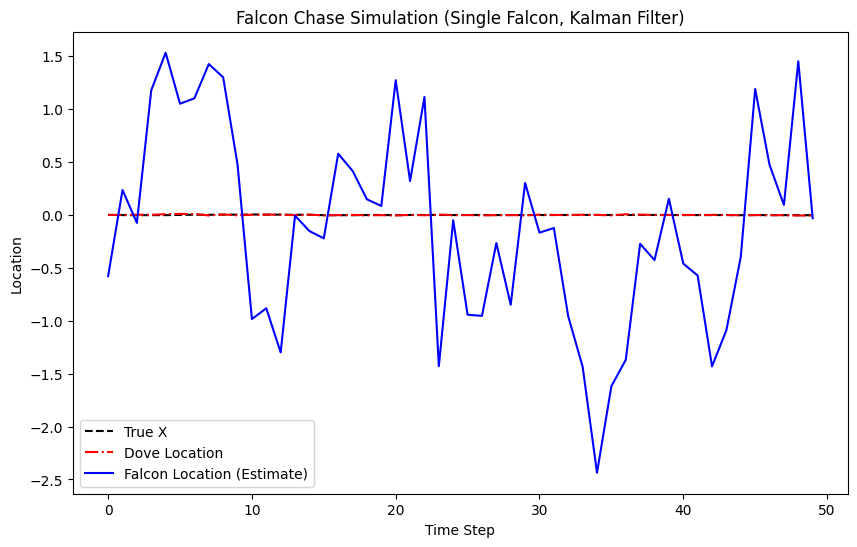

done


In [39]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

from martingale.processes.browngen import brown_gen

from martingale.processes.browngen import brown_gen

def falcon_kalman_sim_one_falcon(num_steps,Q=1.0, alpha_sigma=0.01):
    """
    Generator for one falcon chasing a dove. Yields records of the form:
    {
      'x': <true x from brown_gen()>,
      'dove_location': <dove location y from brown_gen()>,
      'falcon_location': <the falcon's Kalman-filtered estimate of x>
    }

    Arguments:
      Q: process noise variance (for the Kalman filter's internal model).
      alpha_sigma: amplitude for random-walking the measurement noise sigma.
    """
    bg = brown_gen(n=num_steps+1)  # Brownian generator providing {x, y}

    # Kalman state for the single falcon
    m = 0.0     # initial mean
    P = 1e6     # large initial variance for big uncertainty

    # Start measurement noise around 1–2
    sigma = 1.0 + random.random()

    while True:
        # Draw the next Brownian sample
        sample = next(bg)
        x_true = sample["x"]
        dove_loc = sample["y"]

        # Random-walk the noise level
        sigma += alpha_sigma * np.random.randn()
        sigma = max(0.01, sigma)  # keep it positive
        R = sigma ** 2            # measurement noise variance

        # 1) Predict step
        m_prior = m
        P_prior = P + Q

        # 2) Measurement (we measure dove_loc)
        z = dove_loc + np.random.randn() * sigma

        # 3) Update step
        K = P_prior / (P_prior + R)        # Kalman gain
        m_post = m_prior + K * (z - m_prior)
        P_post = (1 - K) * P_prior

        # Update stored state
        m = m_post
        P = P_post

        yield {
            "x": x_true,
            "dove_location": dove_loc,
            "falcon_location": m_post
        }

def run_and_plot_one_falcon(num_steps=50, Q=1.0, alpha_sigma=0.01):
    sim = falcon_kalman_sim_one_falcon(num_steps=num_steps,Q=Q, alpha_sigma=alpha_sigma)

    x_series = []
    dove_series = []
    falcon_series = []

    for step in range(num_steps):
        record = next(sim)  # Only one falcon, so just one record
        x_series.append(record["x"])
        dove_series.append(record["dove_location"])
        falcon_series.append(record["falcon_location"])

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(x_series, '--k', label='True X')
    plt.plot(dove_series, '-.r', label='Dove Location')
    plt.plot(falcon_series, '-b', label='Falcon Location (Estimate)')
    plt.title('Falcon Chase Simulation (Single Falcon, Kalman Filter)')
    plt.xlabel('Time Step')
    plt.ylabel('Location')
    plt.legend()
    plt.show()

    # Also return the data so we can use it for CTGAN
    return x_series, dove_series, falcon_series

_,_,_ = run_and_plot_one_falcon(num_steps=50, Q=1.0, alpha_sigma=0.01)
print('done')

In [32]:
!pip install numpy pandas matplotlib seaborn sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.0/155.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.1/179.1 kB 12.2 MB/s eta 0:00:00


In [37]:
!pip install --upgrade sdv

In [36]:
!pip show sdv

Name: sdv
Version: 1.17.4
Summary: Generate synthetic data for single table, multi table and sequential data
Home-page: 
Author: 
Author-email: "DataCebo, Inc." <info@sdv.dev>
License: BSL-1.1
Location: /usr/local/lib/python3.11/dist-packages
Requires: boto3, botocore, cloudpickle, copulas, ctgan, deepecho, graphviz, numpy, pandas, platformdirs, pyyaml, rdt, sdmetrics, tqdm
Required-by: 


=== Real Falcon–Dove Data (head) ===
   ChaseID  TimeStep ScenarioName  DoveLocation  FalconLocation
0        0         0   Scenario-0      1.144403        1.355751
1        0         1   Scenario-0      0.910249        1.105032
2        0         2   Scenario-0      2.489462        1.904078
3        0         3   Scenario-0      2.019988        2.210131
4        0         4   Scenario-0      1.556570        1.781198
5        0         5   Scenario-0      1.798532        0.829758
6        0         6   Scenario-0      0.073614        0.321771
7        0         7   Scenario-0     -0.939217        0.100599
8        0         8   Scenario-0     -1.847241       -1.189905
9        0         9   Scenario-0     -0.381592       -1.060299


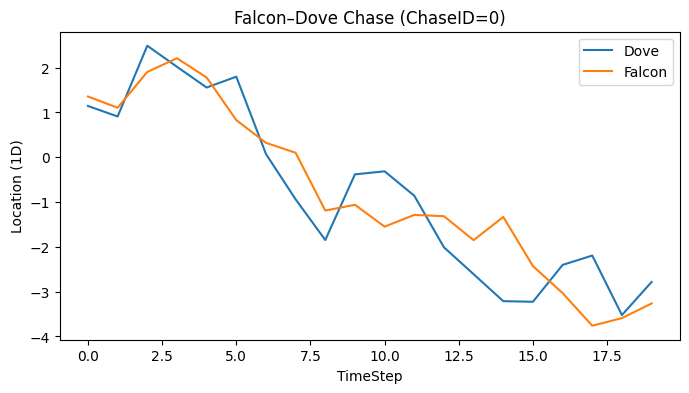

In [51]:
falcon_chase_metadata_dict = {
    "tables": {
        "falcon_chase": {
            "columns": {
                "ChaseID": {
                    "sdtype": "id"
                },
                "TimeStep": {
                    "sdtype": "numerical",
                    "computer_representation": "Int64"
                },
                "ScenarioName": {
                    "sdtype": "categorical"
                },
                "DoveLocation": {
                    "sdtype": "numerical",
                    "computer_representation": "Float"
                },
                "FalconLocation": {
                    "sdtype": "numerical",
                    "computer_representation": "Float"
                }
            },
            "sequence_key": "ChaseID",
            "sequence_index": "TimeStep"
        }
    },
    "relationships": [],
    "METADATA_SPEC_VERSION": "V1"
}



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def simulate_falcon_dove_chase(num_sequences=3, sequence_length=20):
    """
    Create multiple 'chase sessions' between a falcon and a dove in 1D.

    Returns:
      df (pd.DataFrame) with columns:
        ChaseID, TimeStep, ScenarioName, DoveLocation, FalconLocation
    """
    data = []
    np.random.seed(42)

    for chase_id in range(num_sequences):
        # Arbitrary scenario name as a possible context column
        scenario_name = f"Scenario-{chase_id}"

        # Random initial positions
        dove_pos = np.random.randn()
        falcon_pos = dove_pos + np.random.randn()

        for t in range(sequence_length):
            # Dove moves randomly
            dove_step = np.random.normal(loc=0.0, scale=1.0)
            dove_pos += dove_step

            # Falcon tries to move closer to the dove with some random noise
            alpha = 0.3  # chase speed factor
            chase_noise = np.random.normal(loc=0, scale=0.5)
            falcon_pos += alpha * (dove_pos - falcon_pos) + chase_noise

            data.append({
                'ChaseID': chase_id,
                'TimeStep': t,
                'ScenarioName': scenario_name,
                'DoveLocation': dove_pos,
                'FalconLocation': falcon_pos
            })

    df = pd.DataFrame(data)
    return df

# Simulate 3 chase sessions, each with 20 time steps
df_real = simulate_falcon_dove_chase(num_sequences=3, sequence_length=20)
print("=== Real Falcon–Dove Data (head) ===")
print(df_real.head(10))

# Optional: quick plot of one chase session
def quick_plot(df, chase_id=0):
    subset = df[df['ChaseID'] == chase_id]
    plt.figure(figsize=(8, 4))
    plt.plot(subset['TimeStep'], subset['DoveLocation'], label='Dove')
    plt.plot(subset['TimeStep'], subset['FalconLocation'], label='Falcon')
    plt.title(f"Falcon–Dove Chase (ChaseID={chase_id})")
    plt.xlabel("TimeStep")
    plt.ylabel("Location (1D)")
    plt.legend()
    plt.show()

quick_plot(df_real, chase_id=0)


In [52]:
import numpy as np
import pandas as pd

# SDV imports
from sdv.metadata import Metadata
from sdv.sequential import PARSynthesizer

###############################################################################
# 1. Load or define your metadata
###############################################################################
falcon_chase_metadata_dict = {
    "tables": {
        "falcon_chase": {
            "columns": {
                "ChaseID": {
                    "sdtype": "id"
                },
                "TimeStep": {
                    "sdtype": "numerical",
                    "computer_representation": "Int64"
                },
                "ScenarioName": {
                    "sdtype": "categorical"
                },
                "DoveLocation": {
                    "sdtype": "numerical",
                    "computer_representation": "Float"
                },
                "FalconLocation": {
                    "sdtype": "numerical",
                    "computer_representation": "Float"
                }
            },
            "sequence_key": "ChaseID",
            "sequence_index": "TimeStep"
        }
    },
    "relationships": [],
    "METADATA_SPEC_VERSION": "V1"
}


metadata = Metadata.load_from_dict(falcon_chase_metadata_dict)

###############################################################################
# 2. Prepare your real data (df_real)
###############################################################################
# Example toy data matching the columns in our metadata:
df_real = pd.DataFrame({
    'ChaseID': [0, 0, 0, 1, 1, 1],
    'TimeStep': [0, 1, 2, 0, 1, 2],
    'ScenarioName': ['Desert', 'Desert', 'Desert', 'Forest', 'Forest', 'Forest'],
    'DoveLocation': [0.0, 0.8, 1.7, 2.0, 1.0, 3.0],
    'FalconLocation': [1.0, 1.5, 2.0, 1.5, 1.1, 2.8]
})

# This single DataFrame must contain the columns in your metadata.

###############################################################################
# 3. Initialize PARSynthesizer WITHOUT table_name or entity_columns
###############################################################################
synth = PARSynthesizer(
    metadata=metadata,
    # Do NOT provide table_name or entity_columns,
    # because your version of PARSynthesizer doesn't accept them.
    epochs=10,
    verbose=True
)

###############################################################################
# 4. Fit the Synthesizer on your real data
###############################################################################
# Just pass df_real. If your version is strictly single-table oriented,
# it won't require table_name here either.
synth.fit(df_real)

###############################################################################
# 5. Generate Synthetic Data
###############################################################################
# This typically tries to produce the same number of sequences as the original,
# or you can specify num_sequences.
synthetic_data = synth.sample(num_sequences=2)
print("=== Synthetic Data (head) ===")
print(synthetic_data.head(10))




100%|██████████| 2/2 [00:00<00:00, 47.64it/s]


=== Synthetic Data (head) ===
   ChaseID  TimeStep ScenarioName  DoveLocation  FalconLocation
0  6000583         0       Forest           1.4             1.7
1  6000583         1       Forest           1.4             2.3
2  6000583         2       Desert           1.4             1.6
3   440368         0       Desert           0.5             1.3
4   440368         1       Desert           0.5             2.5
5   440368         2       Desert           1.5             1.7


In [63]:
import random
import numpy as np
import pandas as pd

# Assume falcon_kalman_sim_one_falcon is already defined somewhere else:
# def falcon_kalman_sim_one_falcon(num_steps, Q=1.0, alpha_sigma=0.01):
#     ...
#     yield { "x": x_true, "dove_location": dove_loc, "falcon_location": m_post }

def simulate_falcon_chase_data(num_chases=20000, num_steps=20000, Q=1.0, alpha_sigma=0.01):
    """
    Simulate real data for multiple chase scenarios, each with `num_steps` time steps.
    Returns a DataFrame with columns:
      ['ChaseID', 'TimeStep', 'ScenarioName', 'DoveLocation', 'FalconLocation'].
    """
    data = []
    for chase_id in range(num_chases):
        scenario_name = f"Scenario-{chase_id}"

        # Get a generator for this single chase (one falcon, one dove)
        sim = falcon_kalman_sim_one_falcon(num_steps=num_steps, Q=Q, alpha_sigma=alpha_sigma)

        for t in range(num_steps):
            record = next(sim)
            data.append({
                'ChaseID': chase_id,
                'TimeStep': t,
                'ScenarioName': scenario_name,
                'DoveLocation': record["dove_location"],
                'FalconLocation': record["falcon_location"]
            })

    return pd.DataFrame(data)


# For demonstration, simulate 3 chase sessions, each 30 steps long
df_real = simulate_falcon_chase_data(
    num_chases=3,
    num_steps=30,
    Q=1.0,
    alpha_sigma=0.01
)


from sdv.sequential import PARSynthesizer

# Create the synthesizer, referencing just the metadata
synth = PARSynthesizer(
    metadata=metadata,
    epochs=10,
    verbose=True
)

# Fit on our real falcon–dove data
print('Training ...')
synth.fit(df_real)


synthetic_data = synth.sample(num_sequences=2)
print("\n=== Synthetic Falcon–Dove Synthetic Data (Head) ===")
print(synthetic_data.head(10))

Parameters: {'time_step': np.float64(0.14353597630840095), 'volatility_scale': np.float64(438.03067977557816), 'correlation_rho': np.float64(0.6499965072758813), 'relative_jump_size': np.float64(1.0072989713194045), 'mean_reversion_speed': np.float64(0.87282041048585), 'jump_intensity': np.float64(0.0743635342012982), 'noise_mean_reversion': np.float64(0.391986682787203), 'epsilon_correlation': np.float64(0.1398977165414647), 'relative_noise_scale': np.float64(0.3222813563564322), 'noise_evolution_rate': np.float64(0.3303737074006833)}
Parameters: {'time_step': np.float64(0.12513647359862648), 'volatility_scale': np.float64(0.03129599765470082), 'correlation_rho': np.float64(0.17909382860885237), 'relative_jump_size': np.float64(0.8880328528924234), 'mean_reversion_speed': np.float64(0.5740048096645736), 'jump_intensity': np.float64(0.07090513860558141), 'noise_mean_reversion': np.float64(0.47203230840181115), 'epsilon_correlation': np.float64(0.16460265481805714), 'relative_noise_scal

100%|██████████| 2/2 [00:00<00:00,  8.33it/s]


=== Synthetic Falcon–Dove Synthetic Data (Head) ===
   ChaseID  TimeStep ScenarioName  DoveLocation  FalconLocation
0  5197064         0   Scenario-2    175.028453      216.369269
1  5197064         1   Scenario-1    218.169522      347.543743
2  5197064         2   Scenario-1    546.160367      216.369269
3  5197064         3   Scenario-2    464.763544      166.750406
4  5197064         4   Scenario-0    218.169522      216.369269
5  5197064         5   Scenario-2    556.331668      551.691964
6  5197064         6   Scenario-0    218.169522      216.369269
7  5197064         7   Scenario-0   -228.931029      216.369269
8  5197064         8   Scenario-2    218.169522      216.369269
9  5197064         9   Scenario-2    852.902118      216.369269


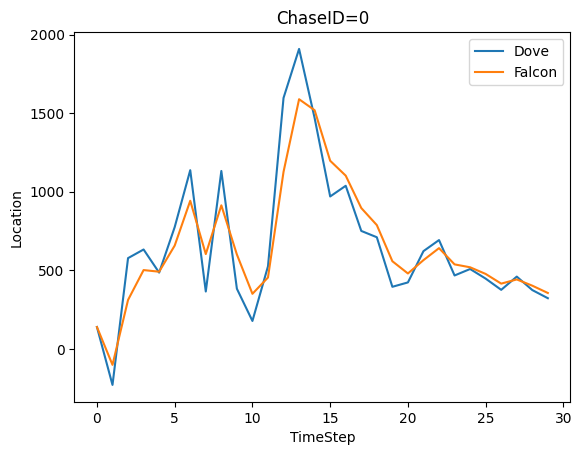

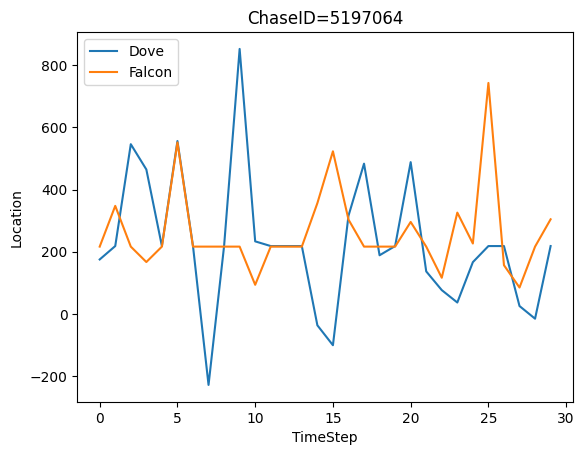

In [64]:
import matplotlib.pyplot as plt

def plot_chase(df, chase_id):
    subset = df[df['ChaseID'] == chase_id].sort_values('TimeStep')
    plt.plot(subset['TimeStep'], subset['DoveLocation'], label='Dove')
    plt.plot(subset['TimeStep'], subset['FalconLocation'], label='Falcon')
    plt.title(f"ChaseID={chase_id}")
    plt.xlabel("TimeStep")
    plt.ylabel("Location")
    plt.legend()
    plt.show()

# Example usage with real data
plot_chase(df_real, chase_id=0)

# Example usage with synthetic data (pick a synthetic ChaseID)
if not synthetic_data.empty:
    example_syn_chase_id = synthetic_data['ChaseID'].unique()[0]
    plot_chase(synthetic_data, example_syn_chase_id)


100%|██████████| 2/2 [00:00<00:00,  8.07it/s]


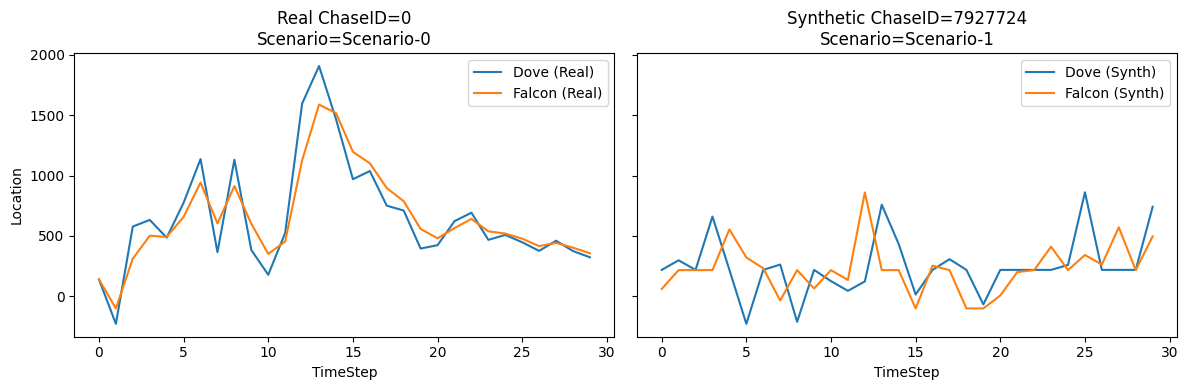

In [65]:
import matplotlib.pyplot as plt

def compare_real_synthetic(
    df_real,
    df_synth,
    chase_id_real=0
):
    """
    Plot one chase session from the real data and one chase session
    from the synthetic data side-by-side to visually compare.
    """

    # 1. Pick the chase from the real data
    real_chase = df_real[df_real['ChaseID'] == chase_id_real].copy()
    if real_chase.empty:
        raise ValueError(f"No real chase with ChaseID={chase_id_real} found.")
    real_chase = real_chase.sort_values('TimeStep')

    # 2. Pick any chase from the synthetic data
    synth_ids = df_synth['ChaseID'].unique()
    if len(synth_ids) == 0:
        raise ValueError("No synthetic chase IDs found.")
    chase_id_synth = synth_ids[0]
    synth_chase = df_synth[df_synth['ChaseID'] == chase_id_synth].copy()
    synth_chase = synth_chase.sort_values('TimeStep')

    # 3. Make side-by-side subplots
    fig, axes = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

    # --- Left: Real data chase
    axes[0].plot(real_chase['TimeStep'], real_chase['DoveLocation'], label='Dove (Real)')
    axes[0].plot(real_chase['TimeStep'], real_chase['FalconLocation'], label='Falcon (Real)')
    scenario_real = real_chase['ScenarioName'].iloc[0]
    axes[0].set_title(f"Real ChaseID={chase_id_real}\nScenario={scenario_real}")
    axes[0].set_xlabel("TimeStep")
    axes[0].set_ylabel("Location")
    axes[0].legend()

    # --- Right: Synthetic data chase
    axes[1].plot(synth_chase['TimeStep'], synth_chase['DoveLocation'], label='Dove (Synth)')
    axes[1].plot(synth_chase['TimeStep'], synth_chase['FalconLocation'], label='Falcon (Synth)')
    scenario_synth = synth_chase['ScenarioName'].iloc[0] if 'ScenarioName' in synth_chase else 'N/A'
    axes[1].set_title(f"Synthetic ChaseID={chase_id_synth}\nScenario={scenario_synth}")
    axes[1].set_xlabel("TimeStep")
    axes[1].legend()

    plt.tight_layout()
    plt.show()



df_synth = synth.sample(num_sequences=2)
compare_real_synthetic(df_real=df_real,df_synth=df_synth)